In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

In [8]:
dataset = pd.read_csv('SN_m_tot_V2.0.csv', delimiter=';', names=['Year', 'Month', 'Spaced Time','Sunspots','a','b','c'])

In [9]:
dataset.head()

,Year,Month,Spaced Time,Sunspots,a,b,c
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         3277 non-null   int64  
 1   Month        3277 non-null   int64  
 2   Spaced Time  3277 non-null   float64
 3   Sunspots     3277 non-null   float64
 4   a            3277 non-null   float64
 5   b            3277 non-null   int64  
 6   c            3277 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 179.3 KB


In [11]:
dataset.columns

Index(['Year', 'Month', 'Spaced Time', 'Sunspots', 'a', 'b', 'c'], dtype='object')

In [16]:
data = dataset.drop(['Year','Month','Spaced Time','a','b','c'],axis=1)
time = dataset.drop(['Year','Month','Sunspots','a','b','c'],axis=1)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sunspots  3277 non-null   float64
dtypes: float64(1)
memory usage: 25.7 KB


In [17]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Spaced Time  3277 non-null   float64
dtypes: float64(1)
memory usage: 25.7 KB


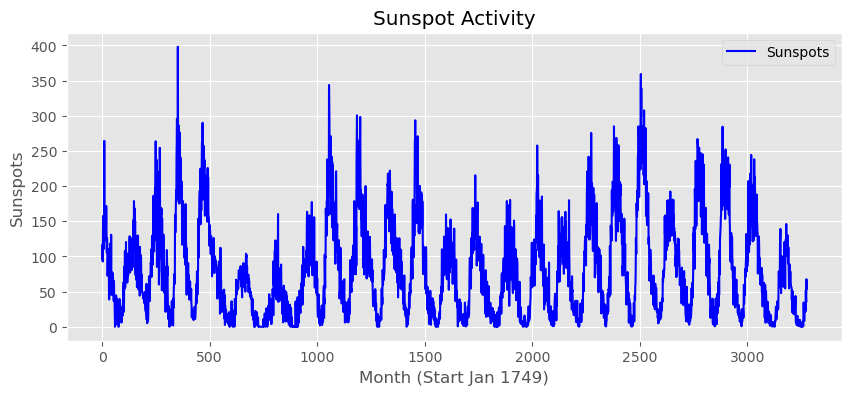

In [19]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.show()

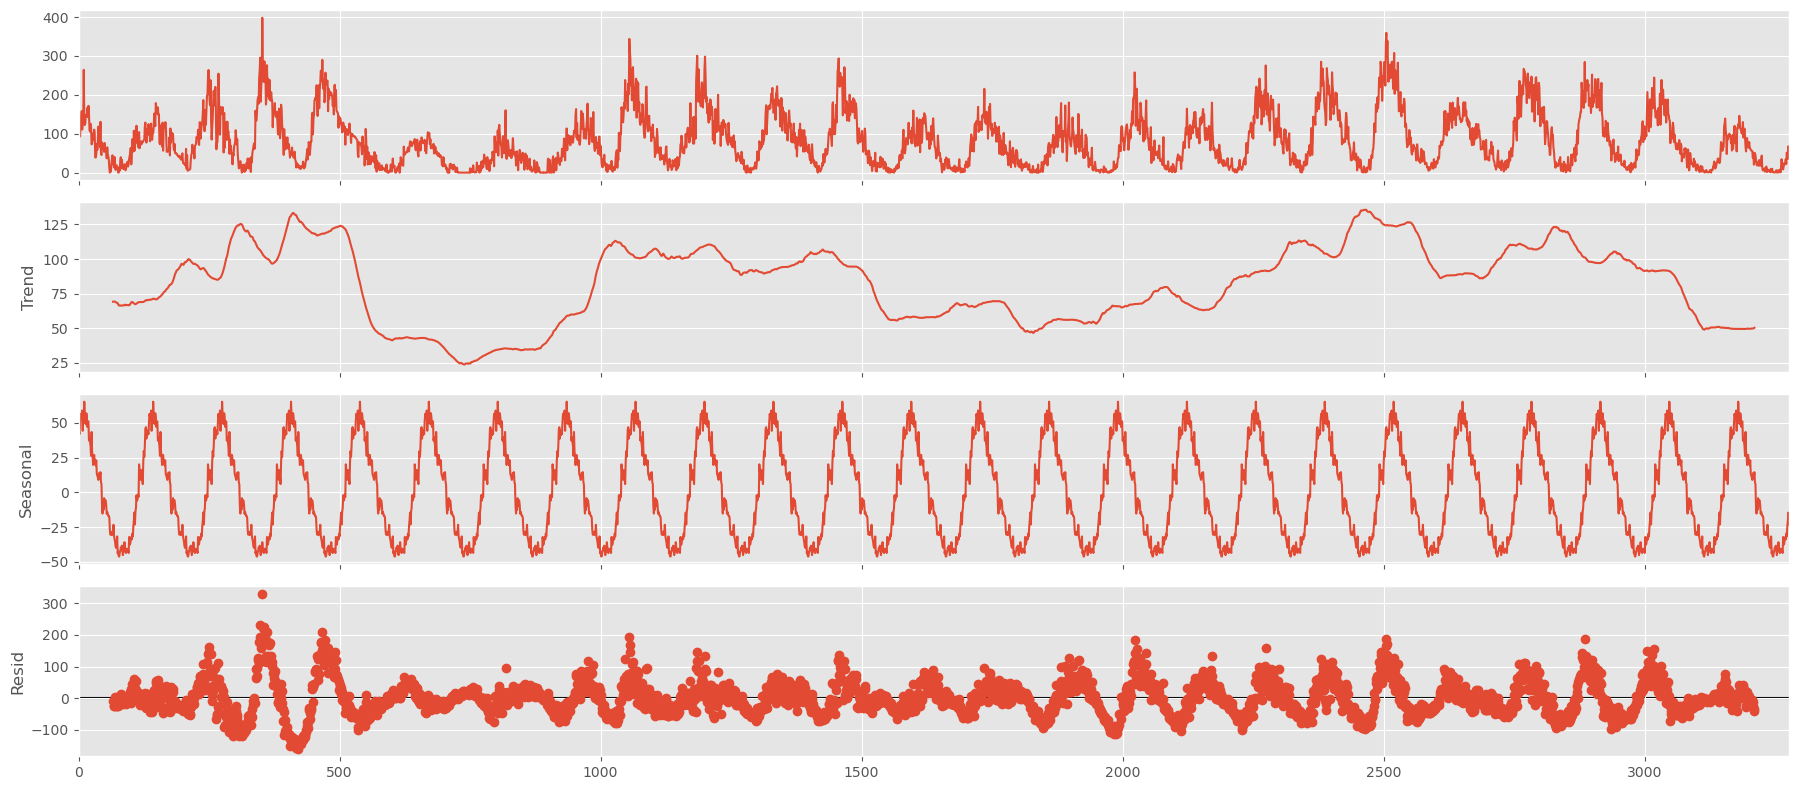

In [22]:
# Time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period = 132)
fig = decomposition.plot()
plt.show()

In [23]:
data_raw = data.to_numpy()

In [40]:
# Normalize data to zero mean and unit variance
# scaler = StandardScaler()
scaler = QuantileTransformer(output_distribution='uniform')
# scaler = PowerTransformer()

data_scaled = scaler.fit_transform(data_raw)

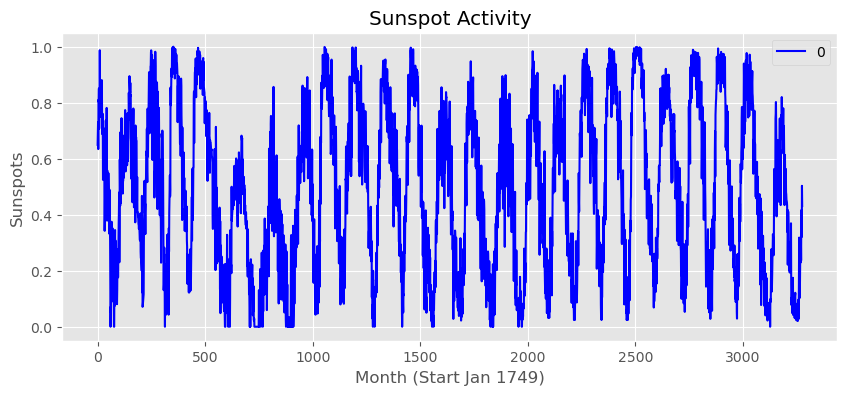

In [41]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.show()

In [42]:
data_scaled.shape

(3277, 1)

In [69]:
# Split data using 70/30 train/test split
split = round(len(data)*.7)
number_targets = len(data) - split
data_targets = data.to_numpy()[split:]

train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)

(2294, 1)
(983, 1)


In [49]:
# Parameters
n_input = number_targets
n_features = 1
batch_size = 10
epochs = 15

# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32)

## Create the model and train it - Vanilla LSTM

In [50]:
print(train_x.shape)
print(train_y.shape)

torch.Size([1311, 983, 1])
torch.Size([1311, 1])


In [51]:
# Dataset and DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
# Train the model
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [53]:
# Make future predictions - run just once
# Initialize and train the model
model = LSTMModel(n_input, n_features)
train_model(model, train_loader, epochs)

model.eval()
pred_list = []
batch = train_data[-n_input:].reshape((1, n_input, n_features))
batch = torch.tensor(batch, dtype=torch.float32)

with torch.no_grad():
    for i in range(n_input):
        pred = model(batch).item()
        pred_list.append(pred)
        batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

# Inverse transform the predictions
predicted_sales = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1))

# Create a dataframe for predictions
df_predict = pd.DataFrame(predicted_sales, index=data[-n_input:].index, columns=['Prediction'])
print(df_predict)

      Prediction
2294  104.309094
2295  107.162794
2296  108.471112
2297  109.411529
2298  110.515159
...          ...
3272  158.198758
3273  158.198758
3274  158.198758
3275  158.198758
3276  158.198758

[983 rows x 1 columns]


In [54]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [55]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
n_runs = 2
store = np.zeros((n_input, n_runs))
model = LSTMModel(n_input, n_features)

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = LSTMModel(n_input, n_features)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
            batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

In [56]:
print(final_vanilla.shape)
print(final_vanilla)

(983,)
[108.61227118 108.0510637  113.7371513  115.22678439 116.0292708
 130.81998871 120.90393847 129.61452317 130.24448328 120.90955086
 115.61644115 121.5033587  144.04119318 130.58848177 134.64562164
 135.98770899 146.03517697 147.29643037 148.63719122 143.29151467
 151.63701574 138.57486536 146.76054488 159.73544677 157.48553643
 152.74513054 171.79321139 189.8439032  173.13358928 194.3124086
 198.45893226 206.20775524 201.15901225 209.16055158 198.2495986
 277.51347123 277.92800292 281.00779645 203.8348628  275.97153472
 274.51148255 274.13334273 197.07105779 159.21504149 203.92510601
 277.62003657 203.46347077 188.49516554 194.06294749 206.34936863
 181.13007061 199.23731844 189.08761634 171.97472775 171.14007101
 184.38114981 167.47728944 175.83665233 165.99401958 176.06352543
 172.55920286 170.53947752 157.49717725 141.80848977 166.79089765
 179.58335133 179.06733077 184.41030536 199.57063212 221.93546437
 193.69999183 285.22314304 307.3854535  247.75513067 237.32770083
 260.3

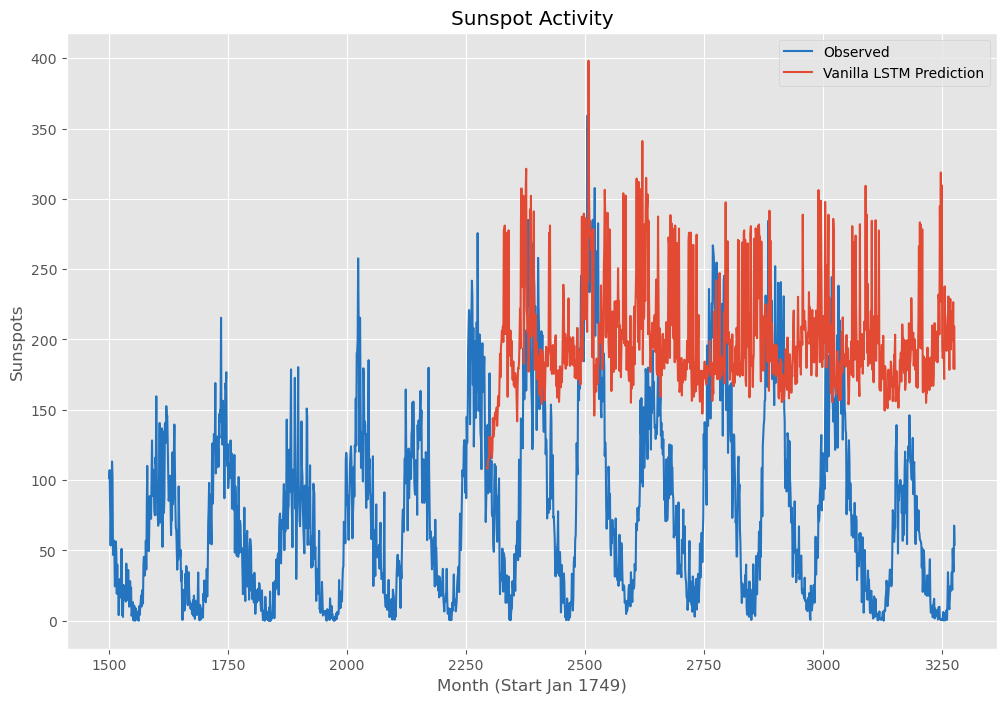

In [59]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data[1500:],label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.legend()
plt.show()

In [67]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / (y_true+0.001))) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

In [68]:
vanilla_lstm = performance(data_targets,final_vanilla)
vanilla_lstm

{'MSE': 18901.83, 'RMSE': 137.48, 'MAPE': 21933.55}

## Stacked LSTM


In [75]:
# Define the stacked LSTM model
class StackedLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(StackedLSTMModel, self).__init__()
        # First LSTM layer (returns entire sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, dropout=0.25 ,num_layers=2)
        # Second LSTM layer (returns entire sequences)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        #manual dropout
        self.dropout = nn.Dropout(0.2)
        # Fully connected layers
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        x = lstm_out2[:, -1, :]  # Get the last time step output
        #x = self.dropout(x)  # Apply dropout here
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [76]:
# Train and predict multiple times
n_runs = 3
epochs = 25
store2 = np.zeros((number_targets, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_stacked = StackedLSTMModel(n_input=n_input, n_features=n_features)
    
    # Train the model
    train_model(model_stacked, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_stacked(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

    # Inverse transform the predictions and store them
    store2[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_stacked = np.mean(store2, axis=1)
print(final_stacked)

Epoch [25/200], Loss: 0.1142
Epoch [50/200], Loss: 0.0647
Epoch [75/200], Loss: 0.0235
Epoch [100/200], Loss: 0.0419
Epoch [125/200], Loss: 0.0246
Epoch [150/200], Loss: 0.0185
Epoch [175/200], Loss: 0.0055
Epoch [200/200], Loss: 0.0119
Epoch [25/200], Loss: 0.1178
Epoch [50/200], Loss: 0.0867
Epoch [75/200], Loss: 0.0849
Epoch [100/200], Loss: 0.0231
Epoch [125/200], Loss: 0.0225
Epoch [150/200], Loss: 0.0130
Epoch [175/200], Loss: 0.0177
Epoch [200/200], Loss: 0.0075
Epoch [25/200], Loss: 0.0432
Epoch [50/200], Loss: 0.0277
Epoch [75/200], Loss: 0.0626
Epoch [100/200], Loss: 0.0387
Epoch [125/200], Loss: 0.0301
Epoch [150/200], Loss: 0.0148
Epoch [175/200], Loss: 0.0169
Epoch [200/200], Loss: 0.0113
[1.06465344 1.00622815 0.88432573 0.70875332 0.41785911 0.22605822
 0.15530138 0.14367446 0.14764601 0.15676239 0.41363509 0.86928741
 1.01961099 0.98122467 0.87976828 0.71365624 0.44665022 0.24298827
 0.16356253 0.16487954 0.16208478 0.18205159 0.39495414 0.75580746
 0.9524481  0.9512396

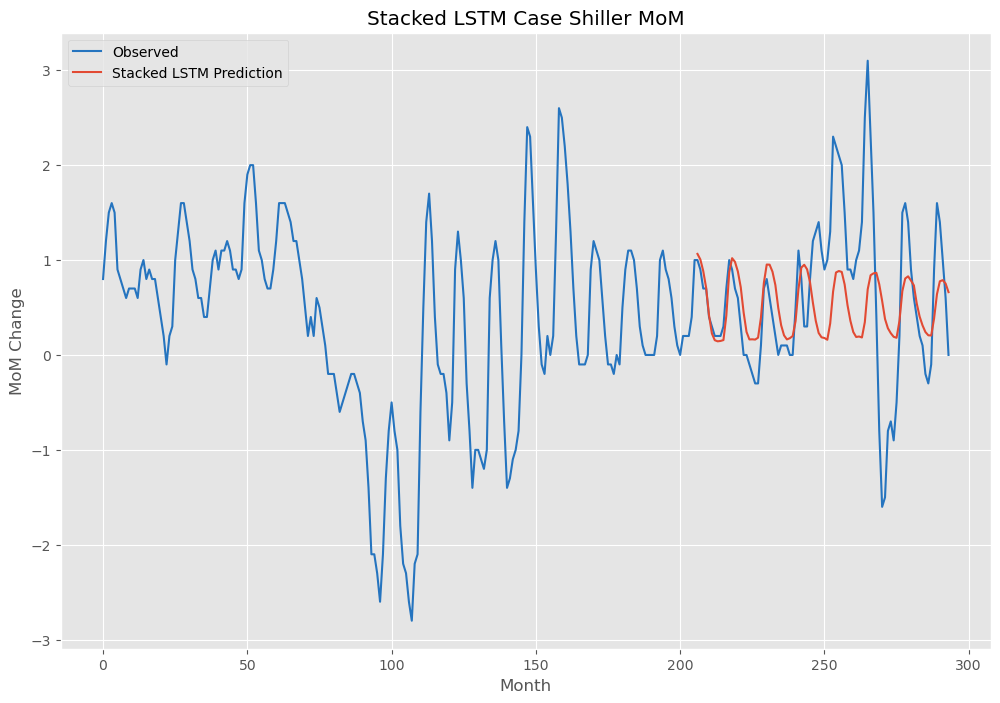

In [77]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data[1500:],label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction")
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.legend()
plt.show()

In [78]:
stacked_lstm= performance(data_targets,final_stacked)
stacked_lstm

/var/folders/tf/xgr43d3x3gv_27t5cflz7xz00000gp/T/ipykernel_4020/2843865680.py:2: RuntimeWarning: Mean of empty slice.
  mse = ((y_pred - y_true) ** 2).mean()
/opt/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


{'MSE': nan, 'RMSE': nan, 'MAPE': nan}